# Mixture Models+Model orden selection 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

In [2]:
def density_gaussian_multivariate(x, p, mu, sigma):
    """Retournes la densité d'une loi gaussienne multivariée

    Args:
        p (integer): dimension
        mu (array): vecteur de moyenne
        sigma (array): matrice de covariance

    Returns:
        array: densité de la loi gaussienne multivariée
    """
    return 1/((2*np.pi)**(p/2)*np.linalg.det(sigma)**0.5)*np.exp(-0.5*np.dot(np.dot((x-mu).T, np.linalg.inv(sigma)), (x-mu)))

In [3]:
class my_GMM():
    
    def __init__(self, K):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array containing covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.K = K
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        self.alpha_ = np.ones(self.K)/self.K
        self.mu_ = np.random.rand(self.K, X.shape[1])
        self.Sigma_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)])
        n = X.shape[0]

        convergence = False
        while not(convergence):
            # Compute conditional probability matrix
            condition_prob_matrix = self.compute_proba(X)
            
            # Update alpha
            alpha = np.mean(condition_prob_matrix, axis=0)
            
            # Update mu
            mu = np.dot(condition_prob_matrix.T, X)/np.sum(condition_prob_matrix, axis=0)[:, None]
            
            # Update Sigma
            Sigma = self.Sigma_
            for k in range(self.K):
                Sigma[k] = np.dot((X-mu[k]).T, np.dot(np.diag(condition_prob_matrix[:, k]), (X-mu[k])))/np.sum(condition_prob_matrix, axis=0)[k]
            
            # Check convergence
            if (np.linalg.norm(alpha - self.alpha_) + np.linalg.norm(mu - self.mu_) + np.linalg.norm(Sigma - self.Sigma_)) < 1e-6:
                convergence = True
            
            # Update cond_prob_
            self.cond_prob_ = condition_prob_matrix
            self.alpha_ = alpha
            self.mu_ = mu
            self.Sigma_ = Sigma
        
        # Update labels_
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        # TODO
        return np.argmax(self.compute_proba(X), axis=1)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        p = X.shape[1]
        condition_prob_matrix = np.zeros((n, self.K))

        sommes = []
        for i in range(n):
            somme = 0
            for l in range(self.K):
                somme += self.alpha_[l]*density_gaussian_multivariate(X[i], p, self.mu_[l], self.Sigma_[l])
            sommes.append(somme)

        for i in range(n):
            for k in range(self.K):
                condition_prob_matrix[i, k] = (self.alpha_[k]*density_gaussian_multivariate(X[i], p, self.mu_[k], self.Sigma_[k]))/(sommes[i])
        
        return condition_prob_matrix

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

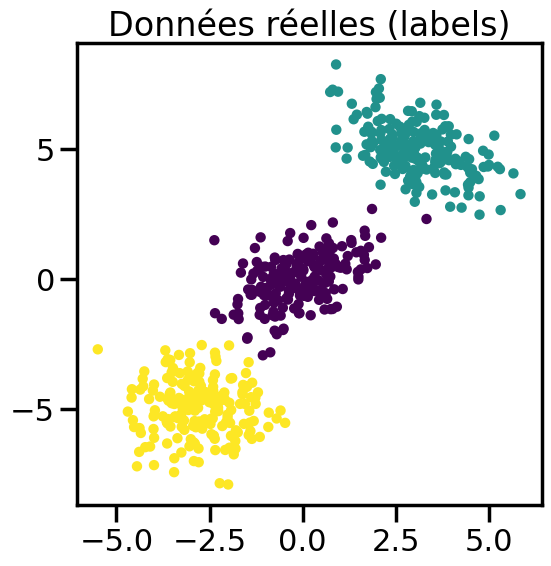

In [4]:
# Générer des données à partir d'un mélange de 3 gaussiennes
np.random.seed(42)

# Moyennes des gaussiennes
mu1 = [0, 0]
mu2 = [3, 5]
mu3 = [-3, -5]

# Matrices de covariance des gaussiennes
Sigma1 = [[1, 0.5], [0.5, 1]]
Sigma2 = [[1, -0.5], [-0.5, 1]]
Sigma3 = [[1, 0], [0, 1]]

# Générer les points
X1 = np.random.multivariate_normal(mu1, Sigma1, 200)
X2 = np.random.multivariate_normal(mu2, Sigma2, 200)
X3 = np.random.multivariate_normal(mu3, Sigma3, 200)

# Regrouper les points
X = np.vstack([X1, X2, X3])

# Labels réels
y_true = np.array([0]*200 + [1]*200 + [2]*200)

# Affichage des données générées
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', marker='o', s=30)
plt.title('Données réelles (labels)')
plt.show()

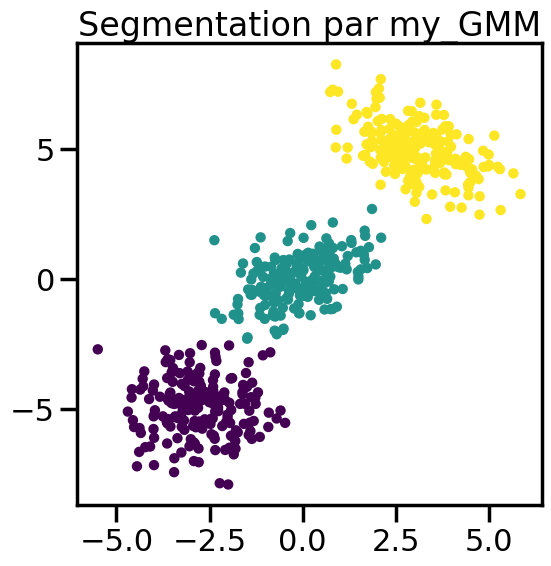

In [5]:
# Appliquer l'implémentation de GMM
gmm_model = my_GMM(K=3)
gmm_model.fit(X)

# Récupérer les labels prédits par GMM
y_gmm = gmm_model.labels_

# Affichage des résultats de GMM
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='viridis', marker='o', s=30)
plt.title('Segmentation par my_GMM')
plt.show()

c:\Users\victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


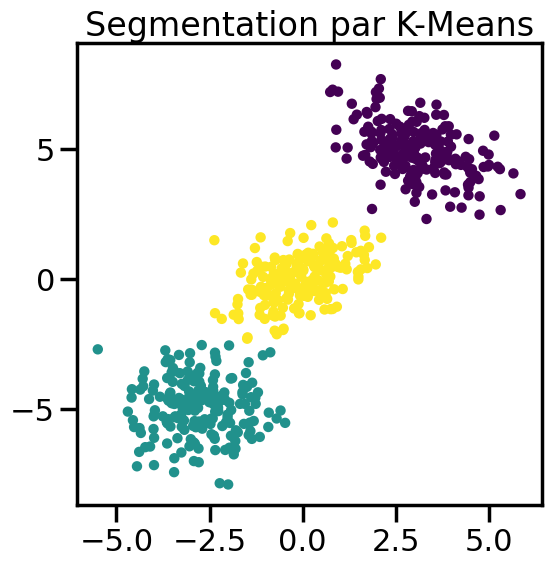

In [6]:
# Appliquer K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Affichage des résultats de K-Means
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', marker='o', s=30)
plt.title('Segmentation par K-Means')
plt.show()